In [1]:
#importing various packages that we will use
import pandas as pd
import numpy as np
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from scipy.optimize import minimize
from scipy.optimize import Bounds
import pdb
import datetime as dt
import matplotlib.pyplot as plt

param = {'duration': {'x_SPX': 0, 'x_Oil': 0, 'x_DXY': 0,'x_UST_10Y': 9.25,'x_VIX': 0, 
                      'x_IG_Spread': 7.5, 'x_HY_Spread': 4.0,'y_EM_Spread': 5},
         'carry': {'x_SPX': 1.9, 'x_Oil': 0, 'x_DXY': 0,'x_UST_10Y': 3.0,'x_VIX': 0, 
                   'x_IG_Spread': 3.6, 'x_HY_Spread': 5.4, 'y_EM_Spread': 5.2}, 
         'shift': {'x_SPX': 0, 'x_Oil': 0, 'x_DXY': 0,'x_UST_10Y': 0,'x_VIX': 0, 
                   'x_IG_Spread': 0, 'x_HY_Spread': 0, 'y_EM_Spread': 0}}

test_dir = r'C:\Users\Home\Documents\GitHub\Spread_Model_2.0'
dt_today = dt.datetime.today().strftime('%Y%m%d')

C:\Users\Home\Documents\Python\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
def read_data(fl_name, periods = 1, shift = 0): #setting default filename to be used unless specified
    fl = os.path.join(test_dir, fl_name) #joining directory and filename
    df = pd.read_csv(fl, header = 0, parse_dates = True) #reading csv file from source into a dataframe
    
    df.columns = ['Date', 'x_SPX', 'x_Oil', 'x_DXY', 'x_UST_10Y', 'x_VIX', 
                  'y_EM_Spread', 'x_IG_Spread', 'x_HY_Spread'] # setting column names for df
    
    df.drop(['x_VIX'], axis = 1, inplace = True)

    df.loc[:, 'Date'] = pd.to_datetime(df['Date']) #converting date into datetime format for pandas
#     df.loc[:, 'x_SPX'] = df['x_SPX'].astype('int64') #coverting SPX data to int
    cols = [col for col in df.columns if '_' in col] #filtering all columns with data
    df.loc[:, 'EM_Spread_raw'] = df['y_EM_Spread']
    df.loc[:, 'EM_Spread_prev'] = df['EM_Spread_raw'].shift(periods - shift)
    df.loc[:, 'y_EM_Spread'] = df['y_EM_Spread'].shift(-shift)
    df1 = periodic_change(df, cols = cols, periods = periods)
    df2 = periodic_total_return(df1, cols = cols, periods = periods) #calculating daily total return using custom function

#     df2.dropna(axis = 0, inplace = True) #remove day1 data (no change, return data avl)
    
    return df2

def periodic_change(df, cols, periods = 1):
    for col in df[cols]:
        df.loc[:, col + '_chg'] = df[col].diff(periods = periods) #calculating change given period

    return df


def periodic_total_return(df, cols, periods = 1, ov_period = None):
    if ov_period is None:
        period_carry = periods
    else:
        period_carry = ov_period
    for col in df[cols]:
        df.loc[:, col + '_carry_rtn'] = param['carry'][col] / 100 / 360 * period_carry #Periodic Carry
        duration = param['duration'][col]
        if duration == 0:
            df.loc[:, col + '_price_rtn'] = df[col].pct_change(periods = periods) #Pct Change for price based inputs
        if duration != 0:
            df.loc[:, col + '_price_rtn'] = df[col].diff(periods = periods) * -1 * duration / 10000 #Spread in bp * Duration converted to a %age of 1
        df.loc[:, col + '_total_rtn'] = df.loc[:, col + '_carry_rtn'] + df.loc[:, col + '_price_rtn'] # Total Return = Carry + Px Return
    
    return df

In [3]:
def reg_m(df, typ = 'chg'):
    f, col_y, col_x = formula_create(df, typ)
#     print (f, '\n', col_y, '\n', (df.loc[:, [col for col in df.columns if '_total_rtn' in col]].head()))
    model = smf.ols(formula = f, data=df)
    results = model.fit()
    
    df_fitval = pd.DataFrame({'y_EM_Spread_pred': results.fittedvalues})
    df_resid = pd.DataFrame({'y_EM_Spread_resid': results.resid})
    
    df = df.merge(df_fitval, how='outer', left_index=True, right_index=True)
    df = df.merge(df_resid, how='outer', left_index=True, right_index=True)
#     df.loc[:, 'y_EM_Spread_resid'] = round(df['y_EM_Spread_resid'] / df[col_y] * 100, 0)
    
    df_vif_input = df.loc[:, col_x]
    X = df_vif_input
#     X = add_constant(df_vif_input)
    df_vif = pd.DataFrame({'Variables': X.columns,
                           'VIF_Values': [vif(X.values, i) for i in range(X.shape[1])]}).set_index('Variables')
    return results, df, df_vif, col_x

def formula_create(df, typ):
    if typ == 'chg':
        cols_x = [col for col in df.columns if ('_chg' in col) & ('x_' in col[:2])]
        cols_y = [col for col in df.columns if ('_chg' in col) & ('y_' in col[:2])]
        formula_text = '{} ~ {} - 1'.format(cols_y[0], ' + '.join(cols_x)) #dropping intercept
        
    elif typ == 'total_rtn':
        cols_x = [col for col in df.columns if ('_total_rtn' in col) & ('x_' in col[:2])]
        cols_y = [col for col in df.columns if ('_total_rtn' in col) & ('y_' in col[:2])]
        formula_text = '{} ~ {} - 1'.format(cols_y[0], ' + '.join(cols_x)) #dropping the constant
        
    elif typ == 'abs':
        cols = [col for col in df.columns if ('_rtn' not in col) & ('_chg' not in col)]
        cols_x = [col for col in cols if 'x_' in col[:2]]
        cols_y = [col for col in cols if 'y_' in col[:2]]
        formula_text = '{} ~ {} - 1'.format(cols_y[0], ' + '.join(cols_x)) #adding regressor terms and dropping the intercept
    
    return formula_text, cols_y, cols_x

In [4]:
def plot_reg(results, df, typ):
    Y = 'y_EM_Spread'
#     cell_text = []
#     cell_text.append([results.params])
    
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.plot(df['Date'], df[Y], color='green', label = Y[2:], linewidth = 0.6)
    ax.set_ylabel(Y, fontsize=16, weight='bold', va='top')
    ax.plot(df['Date'], df[Y + '_pred_val'], color='orange', label = Y[2:] + ' Predict', linewidth = 1)
    
    ax.set_xlabel("Date", fontsize=16, weight='bold', va='top')
    ax.set_title("Linear Regression", fontsize=16, weight='bold', va='top')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis    
    ax2.plot(df['Date'], df[Y + '_resid_val'], color='blue', label = 'Residuals', linewidth= 0.6, ls = 'dashed')
    ax2.set_ylabel('Residual Spread', fontsize=16, weight='bold', va='top')
    
    ax.legend(loc='upper left')
    f = 'R Squared = ' + str(round(results.rsquared,3))
    ax.text(0.8, 0.95, f, horizontalalignment='center', verticalalignment='center',
            fontsize=16, weight='bold', va='top', transform=ax.transAxes)
#     plt.show()
#     print (results.params)
    return plt

In [5]:
def save_output(df, res):
    fl_name = 'Spread_Model_Output_{}.csv'.format(dt_today)
    fl = os.path.join(test_dir, fl_name) #joining directory and filename
    df.to_csv(fl, index = False)
    
    fl_name = 'Spread_Model_OLS_{}.txt'.format(dt_today)
    fl = os.path.join(test_dir, fl_name)
    text_file = open(fl, "w")
    text_file.write(res.summary().as_text())
    text_file.close()
    
    return

In [21]:
def calc_sprd(res, df, cols, typ, typ_calc = 'predict', df_inputs = pd.DataFrame(), ov_period = None, shift = 0):
    Y = 'y_EM_Spread'
    y_last ={'Raw': 0, 'Predict': 0, 'Shock': 0}
    y_predict = 0
    df_res = pd.DataFrame(columns = ['Variable', 'Co-eff']).set_index('Variable')
    df.loc[:, Y + '_pred_v2'], df.loc[:, Y + '_pred_val_v2'] = 0, 0
    
#     pdb.set_trace()
    for col in cols:
        if (typ == 'abs') | (typ_calc == 'predict'):
            df_col = pd.DataFrame({'Variable': [col], 'Co-eff': [res.params[col]]}).set_index('Variable')
            df.loc[:, col + '_coeff'] = res.params[col]
            df.loc[:, Y + '_pred_v2'] += df[col] * df[col + '_coeff']
        else:
            col1 = col + '_' + typ
            df_col = pd.DataFrame({'Variable': [col1], 'Co-eff': [res.params[col1]]}).set_index('Variable')
            df[col1 + '_coeff'] = res.params[col1]
            df.loc[:, Y + '_pred_v2'] += df[col1] * df[col1 + '_coeff']
        df_res = df_res.append(df_col)
    df.loc[:, Y + '_pred_v2'] -= df[Y + '_carry_rtn']     
    
    if typ_calc == 'predict':
        y_last['Raw'] = df.iloc[-1:][Y[2:] + '_raw'].item()
        resid = df.iloc[-1:][Y + '_resid'].item()
        df2 = df.iloc[-2:]
    elif (typ_calc == 'shock') & (len(df_inputs) != 0):
        y_last['Raw'] = df.iloc[-1:][Y[2:] + '_raw'].item()
        resid = 0
        df1 = pd.concat([df, df_inputs], join = 'outer', sort = 'False')

        if typ == 'abs':
            df2 = df1.iloc[-2:].loc[:, cols]
            for col in cols:
                y_predict += df_res.loc[col, 'Co-eff'] * df2.iloc[-1:][ col]
        if typ == 'chg':
            df2 = periodic_change(df1.iloc[-2:].loc[:, cols], cols = cols, periods = 1)
            for col in cols:
                y_predict += df_res.loc[col + '_chg', 'Co-eff'] * df2.iloc[-1:][col + '_chg'].item()
        if typ == 'total_rtn':
            df2 = periodic_total_return(df1.iloc[-2:].loc[:, cols], cols = cols, periods = 1, ov_period = ov_period)
            y_carry = param['carry'][Y] / 100 / 360 * ov_period
            y_predict -= y_carry
            for col in cols:
                y_predict += df_res.loc[col + '_total_rtn', 'Co-eff'] * df2.iloc[-1:][col + '_total_rtn'].item()
    else:
        print ('Type Calc Error!')
        exit()
    
    if typ == 'abs':
        df.loc[:, Y + '_pred_val'] = df[Y + '_pred_v2']
        y_last['Shock'] = y_predict
        
    elif typ == 'chg':
        df.loc[:, Y + '_pred_val'] = df[Y[2:] + '_prev'] + df[Y + '_pred_v2']
        y_last['Shock'] = y_last['Raw'] + y_predict
        
    elif typ == 'total_rtn':
        df.loc[:, Y + '_pred_val'] = df[Y[2:] + '_prev'] + df[Y + '_pred_v2'] / param['duration'][Y] * 10000 * -1
        y_last['Shock'] = y_last['Raw'] + y_predict / param['duration'][Y] * 10000 * -1
    
    df.loc[:, Y + '_resid_val'] = df[Y] - df[Y + '_pred_val']
    df.loc[:, Y + '_resid_val_v2'] = abs(df[Y] - df[Y + '_pred_val'])
    y_last['Predict'] = df.iloc[-1:][Y + '_pred_val'].item()
    
    df.loc[:, Y[2:] + '_Actual'] = (df[Y[2:] + '_prev'] - df[Y]) \
                                    * param['duration'][Y] / 10000
    df.loc[:, Y + '_resid_v2'] = abs(df[Y[2:] + '_Actual'] - df[Y + '_pred_v2'])
    df.loc[:, 'Pred_dir'] = np.where(df[Y[2:] + '_Actual'] / df[Y + '_pred_v2'] > 0, 1, 0)
    
    if typ_calc == 'predict':
        print ('Current Value vs Model Values :')
        print (Y[2:], ' : ', y_last['Raw'], '\n', Y[2:], ' Predict : ', round(y_last['Predict'], 1),  '\n')
#         print ('Changes :', '\n', df2)
        print ('Direction of predictions :', '\n', df.groupby('Pred_dir').agg({'Date': 'count', 
                                                                               Y + '_resid_v2': np.std,
                                                                               Y + '_resid_val_v2': np.std,
                                                                               Y + '_resid': np.std,
                                                                               Y + '_resid_val': np.std}).round(3))
        print ('\n')
        
    elif typ_calc == 'shock':
        print ('Current Value vs Scenario Values :')
        print (Y[2:], ' : ', y_last['Raw'], '\n', Y[2:], ' Predict : ', round(y_last['Shock'], 1))
#         print ('Coeff : ', '\n', res.params)
        print ('Scenario : ', '\n', df2.loc[:, cols], '\n', 'Predicted Y: ', round(y_predict, 4), '\n\n\n')

    return y_last, df

Current Value vs Model Values :
EM_Spread  :  277 
 EM_Spread  Predict :  300.6 

Direction of predictions : 
           Date  y_EM_Spread_resid_v2  y_EM_Spread_resid_val_v2  \
Pred_dir                                                         
0           30                 0.005                    10.924   
1           70                 0.005                    10.093   

          y_EM_Spread_resid  y_EM_Spread_resid_val  
Pred_dir                                            
0                     0.011                 21.210  
1                     0.008                 15.775  


Current Value vs Scenario Values :
EM_Spread  :  277 
 EM_Spread  Predict :  275.4
Scenario :  
        x_SPX  x_Oil   x_DXY  x_UST_10Y  x_IG_Spread  x_HY_Spread
4787  2730.2  56.46  96.927      3.111         1.28         4.04
0     2700.0  55.00  98.000      3.500         1.50         4.25 
 Predicted Y:  0.0008 





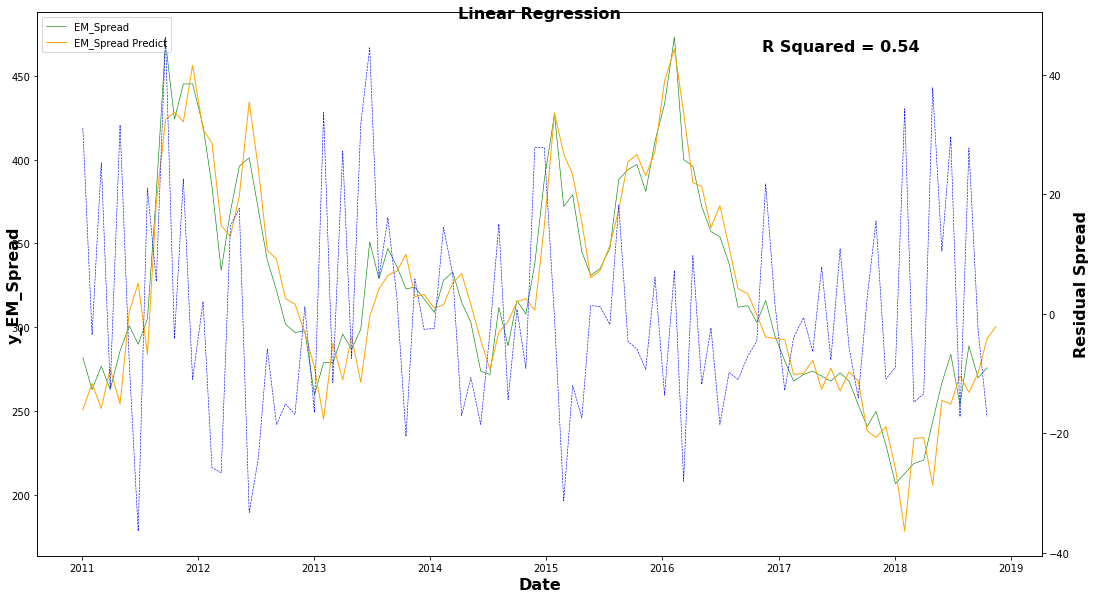

                              OLS Regression Results                             
Dep. Variable:     y_EM_Spread_total_rtn   R-squared:                       0.540
Model:                               OLS   Adj. R-squared:                  0.511
Method:                    Least Squares   F-statistic:                     18.22
Date:                   Fri, 16 Nov 2018   Prob (F-statistic):           7.01e-14
Time:                           11:27:29   Log-Likelihood:                 326.14
No. Observations:                     99   AIC:                            -640.3
Df Residuals:                         93   BIC:                            -624.7
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [22]:
periods = 20
overlap = 0
last = 2000
shift = 3
typ = 'total_rtn' #Types = abs, chg, total_rtn

df = read_data(fl_name = 'Spread_Model_Sample_Data.csv', periods = periods, shift = shift)
df1 = df[-last:].copy() #slicing dataset to keep only the 'last' datapoints
df1.sort_values(['Date'], ascending = False, inplace = True) #sort dates in reverse chronological order
df2 = df1[:: (periods - overlap)].copy() #create a non-rolling series by selecting every 'period' data less 'overlap' if allowed
df2.sort_values(['Date'], ascending = True, inplace = True) #sort dates in chronological order and save into same variable
# print (df2.head())
# res, df1_2 = reg_m(df1, 'total_rtn') #Types = abs, chg, total_rtn
# print (res.summary())
res, df2_2, s, cols = reg_m(df2, typ = typ)
y, df_2_3 = calc_sprd(res, df2_2, cols, typ, typ_calc = 'predict')
plt = plot_reg(res, df_2_3, typ)

#Shock / Scenario Analysis

inputs = {'x_SPX': [2700], 
          'x_Oil': [55], 
          'x_DXY': [98],
          'x_UST_10Y': [3.5], 
          'x_IG_Spread': [1.5], 
          'x_HY_Spread': [4.25]}
ov_period = 30 #calendar days
df_inputs = pd.DataFrame.from_dict(inputs) #convert dict into df
# print (df_inputs)
cols = [col for col in df_inputs.columns] #make a list of all columns in inputs
# print (cols)
y = calc_sprd(res, df2_2, cols, typ, typ_calc = 'shock', df_inputs = df_inputs, ov_period = ov_period)

# sol = minimize(res.rsquared * -1, param['shift'],method='SLSQP',bounds=bnds,constraints=cons)
plt.show()
print (res.summary(), '\n\n\n', 'Multi-Collinearity Contributions (Variance Inflation Factors): ','\n', s)
save_output(df2_2, res)


In [235]:
fl_name = 'Spread_Model_Output_{}.csv'.format(dt_today)
fl = os.path.join(test_dir, fl_name) #joining directory and filename
df1.to_csv(fl, index = False)

In [129]:
print (df2.loc[:, [col for col in df2.columns if '_total_rtn' in col]].tail())

      x_SPX_total_rtn  x_Oil_total_rtn  x_DXY_total_rtn  x_UST_10Y_total_rtn  \
4717         0.031221        -0.048878         0.003938             0.001564   
4732         0.036842         0.027343        -0.000644             0.001780   
4747         0.025142         0.025195        -0.012970             0.001441   
4762        -0.059481         0.034699         0.005279             0.001500   
4777        -0.054514        -0.143145         0.005493             0.001719   

      y_EM_Spread_total_rtn  
4717               0.007889  
4732              -0.012611  
4747               0.010389  
4762               0.009389  
4777              -0.008611  


In [408]:

cols = ['Date', 'y_EM_Spread', 'EM_Spread_raw', 'EM_Spread_prev', 'y_EM_Spread_pred_val', 'y_EM_Spread_resid_val', 
        'y_EM_Spread_total_rtn', 'y_EM_Spread_pred', 'y_EM_Spread_resid', 'y_EM_Spread_pred_v2', 'y_EM_Spread_resid_v2',
        'EM_Spread_Actual', 'y_EM_Spread_carry_rtn']
print (df2_2.loc[:, cols].tail())
# cols = ['Date', 'EM_Spread_prev', 'y_EM_Spread_pred_val_v2', 'y_EM_Spread_pred_v2',
#         'x_SPX_total_rtn_coeff', 'x_SPX_total_rtn',
#         'x_Oil_total_rtn_coeff', 'x_Oil_total_rtn',
#         'x_DXY_total_rtn_coeff', 'x_DXY_total_rtn',
#         'x_UST_10Y_total_rtn_coeff', 'x_UST_10Y_total_rtn']
# print (df2_2.loc[:, cols].tail())

           Date  y_EM_Spread  EM_Spread_raw  EM_Spread_prev  y_EM_Spread_pred_val  y_EM_Spread_resid_val  y_EM_Spread_total_rtn  y_EM_Spread_pred  y_EM_Spread_resid  y_EM_Spread_pred_v2  y_EM_Spread_resid_v2  EM_Spread_Actual  y_EM_Spread_carry_rtn
4701 2018-07-17        268.0            273           279.0            274.570710              -6.570710               0.008389          0.005104           0.003285             0.002215              0.003285            0.0055               0.002889
4721 2018-08-14        290.0            292           268.0            269.745676              20.254324              -0.008111          0.002016          -0.010127            -0.000873              0.010127           -0.0110               0.002889
4741 2018-09-12        284.0            294           290.0            281.310056               2.689944               0.005889          0.007234          -0.001345             0.004345              0.001345            0.0030               0.002889
4761

In [165]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [224]:
print (res.params.dtype)

float64


In [260]:
import scipy
print (scipy.__version__)

1.1.0
